# Prosumer Behavior Model Training Pipeline and Prediction

In [0]:
%pip install -U mlflow

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
%pip show mlflow

Name: mlflow
Version: 3.7.0
Summary: MLflow is an open source platform for the complete machine learning lifecycle
Home-page: https://mlflow.org
Author: 
Author-email: 
License: Copyright 2018 Databricks, Inc.  All rights reserved.
        
                                        Apache License
                                   Version 2.0, January 2004
                                http://www.apache.org/licenses/
        
           TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION
        
           1. Definitions.
        
              "License" shall mean the terms and conditions for use, reproduction,
              and distribution as defined by Sections 1 through 9 of this document.
        
              "Licensor" shall mean the copyright owner or entity authorized by
              the copyright owner that is granting the License.
        
              "Legal Entity" shall mean the union of the acting entity and all
              other entities that control, ar

In [0]:
import mlflow
#use databricks UC registry
mlflow.set_registry_uri("databricks-uc")

In [0]:
import re
userName = spark.sql("SELECT CURRENT_USER").collect()[0]['current_user()']
userName0 = userName.split("@")[0]
userName0 = re.sub(r"[!#$%&'*+/=?^`{}|.\\-]+", '_', userName0)
userName1 = userName.split("@")[1]
userName = f'{userName0}@{userName1}'
userNameReg = re.sub(r'[@\.]', '_', userName)

#Needed for MLFlow and Serverless
import os
os.environ['SPARKML_TEMP_DFS_PATH'] = '/Volumes/cscie103_catalog_final/gold/data'
os.environ['MLFLOW_DFS_TMP'] = '/Volumes/cscie103_catalog_final/gold/data'

spark.sql('CREATE CATALOG IF NOT EXISTS cscie103_catalog_final');
spark.sql('USE CATALOG cscie103_catalog_final')

spark.sql('CREATE SCHEMA IF NOT EXISTS gold');
spark.sql('USE cscie103_catalog_final.gold')

spark.sql(f'CREATE VOLUME if not exists cscie103_catalog_final.gold.data')

userDir = f"/Volumes/cscie103_catalog_final/gold/data"
data_path_json = f"/Volumes/cscie103_catalog_final/gold/data/json"
data_path_csv = f"/Volumes/cscie103_catalog_final/gold/data/csv"
data_path = data_path_csv
dbutils.fs.mkdirs(f"{data_path}")
dbutils.fs.rm('/Volumes/cscie103_catalog_final/gold/data/checkpoint', True)
spark.sql('DROP TABLE IF EXISTS cscie103_catalog_final.gold.streaming_predictions_tbl')

print('UserDir ' + userDir)
print('userName '+ userName)
print('Database gold')

spark.sql(f"use cscie103_catalog_final.gold")

UserDir /Volumes/cscie103_catalog_final/gold/data
userName lil658@g.harvard.edu
Database gold


DataFrame[]

## Read Prosumer Features Dataset

In [0]:
# Load our features dataset

df = spark.sql(f'''select county_id, county_name
,(case when is_business then 'Business' else 'Consumer' end) AS eic_type
,(case when is_consumption then 'Consumption' else 'Production' end) AS target_type
,(case when t_observ_4hour=0 then '00-04'
    when t_observ_4hour=1 then '04-08' 
    when t_observ_4hour=2 then '08-12' 
    when t_observ_4hour=3 then '12-16' 
    when t_observ_4hour=4 then '16-20' 
    when t_observ_4hour=5 then '20-24' end) AS time_of_day,
product_type,
 data_block_id,
 wh_temperature,
 wh_direct_solar_radiation,
 target from cscie103_catalog_final.gold.county_energy_weather_4hours_mv''')
df = df.repartition('county_id')

display(df.head(10))

county_id,county_name,eic_type,target_type,time_of_day,product_type,data_block_id,wh_temperature,wh_direct_solar_radiation,target
15,VÕRUMAA,Business,Production,08-12,Fixed,234,8.979999999999999,300.26666666666665,254.901
15,VÕRUMAA,Consumer,Consumption,08-12,Spot,96,-11.18,1.8,164.061
15,VÕRUMAA,Business,Production,12-16,Spot,445,-2.8,4.7,4.182
15,VÕRUMAA,Business,Production,08-12,Fixed,598,10.186666666666666,285.93333333333334,71.851
15,VÕRUMAA,Consumer,Consumption,04-08,Fixed,251,2.6849999999999996,56.9,33.842
15,VÕRUMAA,Business,Production,20-24,Spot,184,-0.825,0.0,0.0
15,VÕRUMAA,Consumer,Production,20-24,Fixed,179,0.72,0.0,0.0
15,VÕRUMAA,Business,Consumption,08-12,Spot,186,-7.126666666666667,101.73333333333333,246.182
15,VÕRUMAA,Consumer,Production,04-08,Fixed,29,7.5550000000000015,0.25,0.0
15,VÕRUMAA,Consumer,Consumption,16-20,Spot,274,14.459999999999999,112.2,33.577


### Prep the feature Dataset
DB Free Edition resource constraints limit the feature set. 

In [0]:
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

In [0]:
df.columns

['county_id',
 'county_name',
 'eic_type',
 'target_type',
 'time_of_day',
 'product_type',
 'data_block_id',
 'wh_temperature',
 'wh_direct_solar_radiation',
 'target']

In [0]:
df.show(5)

+---------+-----------+--------+-----------+-----------+------------+-------------+------------------+-------------------------+-------+
|county_id|county_name|eic_type|target_type|time_of_day|product_type|data_block_id|    wh_temperature|wh_direct_solar_radiation| target|
+---------+-----------+--------+-----------+-----------+------------+-------------+------------------+-------------------------+-------+
|       15|    VÕRUMAA|Business| Production|      08-12|       Fixed|          234| 8.979999999999999|       300.26666666666665|254.901|
|       15|    VÕRUMAA|Consumer|Consumption|      08-12|        Spot|           96|            -11.18|                      1.8|164.061|
|       15|    VÕRUMAA|Business| Production|      12-16|        Spot|          445|              -2.8|                      4.7|  4.182|
|       15|    VÕRUMAA|Business| Production|      08-12|       Fixed|          598|10.186666666666666|       285.93333333333334| 71.851|
|       15|    VÕRUMAA|Consumer|Consumpti

### Train/Test split

In [0]:
from pyspark.ml import Pipeline
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [0]:
# Drop rows with NA values
# show the row counts before and after dropping NAs
print('Before dropping NAs:', df.count())
df = df.dropna()
print('After dropping NAs:', df.count())

Before dropping NAs: 2308786
After dropping NAs: 2308266


In [0]:
#Check the total dataset for each county_id
df.groupby("county_id","county_name").count().show()

+---------+-------------+------+
|county_id|  county_name| count|
+---------+-------------+------+
|       15|      VÕRUMAA|172926|
|        1|      HIIUMAA|106812|
|        4|    JÕGEVAMAA|171190|
|       13|     VALGAMAA|140736|
|        8|     PÕLVAMAA|106812|
|        6|     LÄÄNEMAA| 35604|
|        3|     JÄRVAMAA|142416|
|       11|     TARTUMAA|229298|
|        0|     HARJUMAA|247548|
|        2|  IDA-VIRUMAA|133906|
|        7|     PÄRNUMAA|200636|
|       10|     SAAREMAA|155962|
|        9|     RAPLAMAA|142416|
|       14|  VILJANDIMAA|145832|
|        5|LÄÄNE-VIRUMAA|176172|
+---------+-------------+------+



In [0]:
def train_county_model(df):
  #
  #split the data into train and test
  #
  df = df.drop("county_id", "county_name")
  fp_train_df, fp_test_df = df.randomSplit([0.8, 0.2], seed=42)
  print("Final Project Train rows:", fp_train_df.count(), "Final Project Test rows:", fp_test_df.count())

  #
  # Normalize the data and set the pipeline
  #
  #set the numberical cols
  fp_numeric_cols = ['wh_temperature','wh_direct_solar_radiation','data_block_id']
  #set the categorical cols
  fp_categorical_cols = ['eic_type','target_type','product_type','time_of_day']
  #set the imputed if any 
  fp_imputer = Imputer(inputCols=fp_numeric_cols, outputCols=[f"{c}_imputed" for c in fp_numeric_cols])
  #set any indexers for categorical cols
  fp_indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in fp_categorical_cols]
  #One Hotencoding for categorical cols
  fp_ohe = OneHotEncoder(inputCols=[f"{c}_idx" for c in fp_categorical_cols], outputCols=[f"{c}_ohe" for c in fp_categorical_cols], handleInvalid="keep")
  #Vector Assembler for all cols
  fp_assembler_inputs = [f"{c}_imputed" for c in fp_numeric_cols] + [f"{c}_ohe" for c in fp_categorical_cols]
  fp_assembler = VectorAssembler(inputCols=fp_assembler_inputs, outputCol="assembled_features", handleInvalid="keep")
  fp_scaler = StandardScaler(inputCol="assembled_features", outputCol="features", withMean=True, withStd=True)

  #
  # set the pipeline  
  #
  rf = LinearRegression(labelCol="target", featuresCol="features")
  stages = [fp_imputer] + fp_indexers + [fp_ohe, fp_assembler, fp_scaler, rf]
  pipeline = Pipeline(stages=stages)
  #
  # train the model for each county with hyperparameter tuning
  #
  fp_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target", metricName="rmse")
  fp_paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxIter, [1, 3]) \
    .build()
  fp_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=fp_paramGrid, evaluator=fp_evaluator, numFolds=3)
  fp_cv_model = fp_cv.fit(fp_train_df)
  #
  # predict the test data
  #
  fp_predict = fp_cv_model.transform(fp_test_df)
  fp_rmse = fp_evaluator.evaluate(fp_predict)
  print("Test RMSE:", fp_rmse)

  return fp_cv_model, fp_test_df, fp_predict, fp_rmse


In [0]:
from mlflow.models.signature import infer_signature
import time

# loop through each county and train the model
for county_id in df.groupby("county_id").count().toPandas()["county_id"]:
  if county_id in (0,1,2,3,4,6,7,8,9,10,11,13,14,15):
    continue
  print("County:", county_id)
  county_df = df.filter(df.county_id == county_id)
  fp_cv_model, fp_test_df, fp_predict, fp_rmse = train_county_model(county_df)
  # save the model to mlflow

  # Infer signature from data
  fp_model_signature = infer_signature(fp_test_df, fp_predict)
  # Log model to MLflow
  mlflow.spark.log_model(fp_cv_model.bestModel, f"model-{county_id}", registered_model_name=f"fp-model-{county_id}", signature=fp_model_signature)
  # delete it after log it.
  del fp_cv_model
  #sleep 10 seconds
  time.sleep(10)


County: 5
Final Project Train rows: 140914 Final Project Test rows: 35258
Test RMSE: 326.52935924539884


/local_disk0/.ephemeral_nfs/envs/pythonEnv-da47bc43-be67-47bf-b1aa-76611402440f/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/15 17:11:56 WARNING mlflow.utils.requirements_utils: Found pyspark version (4.0.0+databricks.connect.17.2.2) contains a local version label (+databricks.connect.17.2.2). M

### Model Performance Evaluation Summary

* County: 0
Final Project Train rows: 198229 Final Project Test rows: 49319
Test RMSE: 1733.095094770264

 > * 'cscie103_catalog_final.gold.fp-model-0': https://dbc-bf0c22bc-3661.cloud.databricks.com/explore/data/models/cscie103_catalog_final/gold/fp-model-0/version/1?o=3544939500018450

* County: 1
Final Project Train rows: 85264 Final Project Test rows: 21548
Test RMSE: 50.792517636787956

 > * 'cscie103_catalog_final.gold.fp-model-1': https://dbc-bf0c22bc-3661.cloud.databricks.com/explore/data/models/cscie103_catalog_final/gold/fp-model-1/version/1?o=3544939500018450
 
* County: 2
Final Project Train rows: 106998 Final Project Test rows: 26908
Test RMSE: 299.84007294177604

 > * 'cscie103_catalog_final.gold.fp-model-2': https://dbc-bf0c22bc-3661.cloud.databricks.com/explore/data/models/cscie103_catalog_final/gold/fp-model-2/version/1?o=3544939500018450

* County: 4
Final Project Train rows: 136879 Final Project Test rows: 34311
Test RMSE: 198.75035644768352

* County: 5
Final Project Train rows: 140914 Final Project Test rows: 35258
Test RMSE: 326.52935924539884

 > * 'cscie103_catalog_final.gold.fp-model-5': https://dbc-bf0c22bc-3661.cloud.databricks.com/explore/data/models/cscie103_catalog_final/gold/fp-model-5/version/2?o=3544939500018450

* County: 6
Final Project Train rows: 28392 Final Project Test rows: 7212
Test RMSE: 82.67250299226838

* County: 7
Final Project Train rows: 160629 Final Project Test rows: 40007
Test RMSE: 262.99752475029146

 > * 'cscie103_catalog_final.gold.fp-model-7': https://dbc-bf0c22bc-3661.cloud.databricks.com/explore/data/models/cscie103_catalog_final/gold/fp-model-7/version/1?o=3544939500018450

* County: 8
Final Project Train rows: 85264 Final Project Test rows: 21548
Test RMSE: 136.15668810452323

 > * 'cscie103_catalog_final.gold.fp-model-8': https://dbc-bf0c22bc-3661.cloud.databricks.com/explore/data/models/cscie103_catalog_final/gold/fp-model-8/version/1?o=3544939500018450

* County: 9
Final Project Train rows: 113836 Final Project Test rows: 28580
Test RMSE: 126.8987075893832

 > * 'cscie103_catalog_final.gold.fp-model-9': https://dbc-bf0c22bc-3661.cloud.databricks.com/explore/data/models/cscie103_catalog_final/gold/fp-model-9/version/1?o=3544939500018450

* County: 11
Final Project Train rows: 183526 Final Project Test rows: 45772
Test RMSE: 1042.838145532865


### Future Time Series Analysis with Seasonal ARINA or ML RF and XGBoost

In [0]:
df = spark.sql(f'''select county_id, county_name
,(case when is_business then 'Business' else 'Consumer' end) AS eic_type
,(case when is_consumption then 'Consumption' else 'Production' end) AS target_type
,(case when t_observ_4hour=0 then '00-04'
    when t_observ_4hour=1 then '04-08' 
    when t_observ_4hour=2 then '08-12' 
    when t_observ_4hour=3 then '12-16' 
    when t_observ_4hour=4 then '16-20' 
    when t_observ_4hour=5 then '20-24' end) AS time_of_day,
product_type,
 data_block_id,
 wh_temperature,
 wh_direct_solar_radiation,
 t_observ_date,
 t_observ_4hour,
 target from cscie103_catalog_final.gold.county_energy_weather_4hours_mv''')
df = df.repartition('county_id')

display(df.head(10))

county_id,county_name,eic_type,target_type,time_of_day,product_type,data_block_id,wh_temperature,wh_direct_solar_radiation,t_observ_date,t_observ_4hour,target
15,VÕRUMAA,Business,Production,08-12,Fixed,234,8.979999999999999,300.26666666666665,2022-04-23,2,254.901
15,VÕRUMAA,Consumer,Consumption,08-12,Spot,96,-11.18,1.8,2021-12-06,2,164.061
15,VÕRUMAA,Business,Production,12-16,Spot,445,-2.8,4.7,2022-11-20,3,4.182
15,VÕRUMAA,Business,Production,08-12,Fixed,598,10.186666666666666,285.93333333333334,2023-04-22,2,71.851
15,VÕRUMAA,Consumer,Consumption,04-08,Fixed,251,2.6849999999999996,56.9,2022-05-10,1,33.842
15,VÕRUMAA,Business,Production,20-24,Spot,184,-0.825,0.0,2022-03-04,5,0.0
15,VÕRUMAA,Consumer,Production,20-24,Fixed,179,0.72,0.0,2022-02-27,5,0.0
15,VÕRUMAA,Business,Consumption,08-12,Spot,186,-7.126666666666667,101.73333333333333,2022-03-06,2,246.182
15,VÕRUMAA,Consumer,Production,04-08,Fixed,29,7.5550000000000015,0.25,2021-09-30,1,0.0
15,VÕRUMAA,Consumer,Consumption,16-20,Spot,274,14.459999999999999,112.2,2022-06-02,4,33.577


In [0]:
df=df.dropna()

In [0]:
df_county=df.filter((df.target_type=='Production') & (df.county_id==0)).select("t_observ_date","t_observ_4hour","county_id","wh_temperature","wh_direct_solar_radiation","target").orderBy("t_observ_date","t_observ_4hour")
df_county.count()


123774

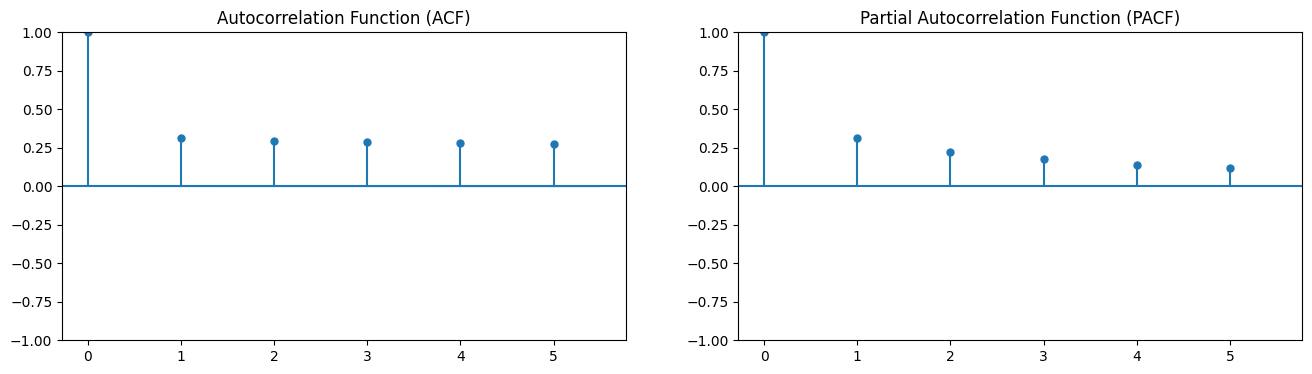

In [0]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

dfcc = df_county.toPandas()
ts = dfcc['target']

fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(ts, lags=5, ax=axes[0])
plot_pacf(ts, lags=5, method='ywm', ax=axes[1])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()